In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor,IsolationForest,ExtraTreesRegressor,GradientBoostingRegressor

from sklearn import preprocessing
import scoring as score # para hacer los reportes de puntajes
from time import time

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes

properati = pd.read_csv('datos/properati_3.csv')
zonas = pd.read_csv('datos/todos_los_barrios.csv')

tipo_puntaje="r2"
iteraciones_de_searchs=20
cv=5

<IPython.core.display.Javascript object>

# Preprocesamiento

In [45]:
#paso features con strings a numericos
le_zona = preprocessing.LabelEncoder()
properati['state_name'] =le_zona.fit_transform(properati['state_name'])

le_barrio = preprocessing.LabelEncoder()
le_barrio.fit(zonas.values)
properati['place_name'] = le_barrio.transform(properati['place_name'])

le_tipo = preprocessing.LabelEncoder()
properati['property_type'] = le_tipo.fit_transform(properati['property_type'])

In [46]:
properati=properati.loc[properati.price_aprox_usd<1e6]
properati=properati.loc[properati.surface_covered_in_m2<7000]
print len(properati)
properati=properati.groupby("place_name").filter(lambda x: len(x)>5)
print len(properati)

126957
126568


In [47]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'])
y = properati["price_aprox_usd"]

In [48]:
Z= zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'],properati["price_aprox_usd"])

outs = IsolationForest(n_jobs=-1,n_estimators=50)
outs.fit(Z)

len(Z)

nuevo_aux =zip(X,outs.predict(Z)) 

nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]
X=nuevo

113911


# XGBoost

In [49]:
%%notify
from xgboost import XGBRegressor
xgb= XGBRegressor(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.3,0.9,0.2)
gamma = np.arange(0.1,0.9,0.1)
subsample = [1]

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3],'gamma':gamma,'subsample':subsample}

search = RandomizedSearchCV(xgb, param_distributions=param_grid ,cv=cv,n_iter=iteraciones_de_searchs,scoring=tipo_puntaje) 
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 154.61 segundos para 20 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.749 (std: 0.002)
Promedio validation score: 0.731 (std: 0.005)
Promedio fit time: 1.564s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.90000000000000013, 'gamma': 0.5, 'min_child_weight': 3}

Puesto: 1
Promedio training score: 0.749 (std: 0.002)
Promedio validation score: 0.731 (std: 0.005)
Promedio fit time: 0.942s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.90000000000000013, 'gamma': 0.20000000000000001, 'min_child_weight': 3}

Puesto: 1
Promedio training score: 0.749 (std: 0.002)
Promedio validation score: 0.731 (std: 0.005)
Promedio fit time: 1.547s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.90000000000000013, 'gamma': 0.10000000000000001, 'min_child_weight': 3}

Puesto: 4
Promedio training score: 0.749 (std: 0.002)
Promedio validation score: 0.731 (std: 0.006)
Promedio fit time: 0.866s
Hiper-parametros: {'subsample': 1, 'learning_rate': 0.900

<IPython.core.display.Javascript object>

In [50]:
xgboost = search.best_estimator_

# RF

In [51]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

criterion = ['mse']
max_features =["auto",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=cv,n_iter=iteraciones_de_searchs,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 397.87 segundos para 20 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.915 (std: 0.001)
Promedio validation score: 0.765 (std: 0.004)
Promedio fit time: 3.555s
Hiper-parametros: {'n_estimators': 95, 'max_features': None, 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.915 (std: 0.001)
Promedio validation score: 0.764 (std: 0.004)
Promedio fit time: 3.452s
Hiper-parametros: {'n_estimators': 80, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 3
Promedio training score: 0.915 (std: 0.001)
Promedio validation score: 0.764 (std: 0.004)
Promedio fit time: 3.505s
Hiper-parametros: {'n_estimators': 95, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 4
Promedio training score: 0.915 (std: 0.001)
Promedio validation score: 0.764 (std: 0.004)
Promedio fit time: 3.725s
Hiper-parametros: {'n_estimators': 85, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 5
Promedio training score: 0.915 (std: 0.001)
Promedio validation score: 0.764 (

<IPython.core.display.Javascript object>

In [52]:
rf= search.best_estimator_

In [12]:
search.score(X_test,y_test)

-7183099846.015913

# ETR

In [53]:
%%notify

etr = ExtraTreesRegressor(n_jobs=-1)

n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"n_estimators":n_estimators}

search = GridSearchCV(etr, param_grid=param_grid ,cv=cv,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 169.22 segundos para 12 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.763 (std: 0.006)
Promedio fit time: 1.895s
Hiper-parametros: {'n_estimators': 85}

Puesto: 2
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.762 (std: 0.006)
Promedio fit time: 2.138s
Hiper-parametros: {'n_estimators': 95}

Puesto: 3
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.762 (std: 0.006)
Promedio fit time: 1.700s
Hiper-parametros: {'n_estimators': 70}

Puesto: 4
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.762 (std: 0.006)
Promedio fit time: 2.057s
Hiper-parametros: {'n_estimators': 90}

Puesto: 5
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.762 (std: 0.006)
Promedio fit time: 1.980s
Hiper-parametros: {'n_estimators': 80}

Puesto: 6
Promedio training score: 0.937 (std: 0.001)
Promedio validation score: 0.762 (std: 0.0

<IPython.core.display.Javascript object>

In [54]:
etr= search.best_estimator_

In [15]:
etr.feature_importances_

array([ 0.20572789,  0.56569375,  0.22857836])

# MLP

In [127]:
from sklearn.neural_network import MLPRegressor

In [128]:
%%notify

mlp = MLPRegressor()

#activation = ["identity", "logistic", "tanh", "relu"]
activation = ["identity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"activation": activation}

search = GridSearchCV(mlp, param_grid=param_grid ,cv=cv,scoring=tipo_puntaje) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 64.37 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -48649291414.936 (std: 1278210409.982)
Promedio validation score: -48843115430.570 (std: 5226556298.293)
Promedio fit time: 10.628s
Hiper-parametros: {'activation': 'identity'}



<IPython.core.display.Javascript object>

In [129]:
mlp=search.best_estimator_

In [130]:
search.score(X_test,y_test)

-43791592775.715477

# Lineales (No usar)

In [55]:
from sklearn.linear_model import Ridge

In [56]:
%%notify

ridge = Ridge()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

ridge.fit(X_train, y_train)
ridge.score(X_test,y_test)

0.38512297260993805

<IPython.core.display.Javascript object>

In [57]:
from sklearn.linear_model import Lasso

In [58]:
%%notify

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

lasso.fit(X_train, y_train)
lasso.score(X_test,y_test)

0.40107496047376923

<IPython.core.display.Javascript object>

# Ensamble

In [59]:
from mlxtend.regressor import StackingRegressor

stregr = StackingRegressor(regressors=[xgb,etr], 
                           meta_regressor=rf)

In [60]:
%%notify
stregr.fit(X_train,y_train)

StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
         regressors=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimato...fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)],
         verbose=0)

<IPython.core.display.Javascript object>

In [61]:
stregr.score(X_test,y_test)

0.7795230526484852

In [62]:
errores = rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:730433.387675
Error minimo:0.0
42928    -19943.337510
94171     72896.903623
110189     1026.315789
98496      6784.448214
83303     -8245.614035
38559    -11344.736842
123697    -5598.640351
68347     -4574.877193
21013     15028.077193
48466      4114.344679
75313     12955.263158
117317    -5791.366160
84382     57509.022556
46966     -2950.292879
64287      4757.447027
5836       -321.052632
108842    -1165.162907
122607     6626.315789
118024    15263.105263
61100    -53562.642105
44434         0.000000
99728      4503.999499
10902      -712.719298
83083    -14422.807018
43514     29201.670844
6503     -14916.546706
99106     -2931.961003
3377     -14547.368421
74761     -1400.000000
50947    -13904.711779
              ...     
78003     -9736.842105
17807     59494.360902
111784   -20326.501587
60986     -2869.515789
58499    -13203.007519
100593   -28060.741336
65135     11147.357895
83819    -19143.073684
108238   -43481.203008
16375     65250.526316
111849     25

In [63]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 23500 de 25314 que tienen mas de 1000 USD de error (92%)


In [64]:
count_max=0
max_error=5000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 18639 de 25314 que tienen mas de 5000 USD de error (73%)


In [65]:
count_max=0
max_error=10000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 14362 de 25314 que tienen mas de 10000 USD de error (56%)


In [66]:
count_max=0
max_error=100000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 1531 de 25314 que tienen mas de 100000 USD de error (6%)


### Errores arriba del maximo

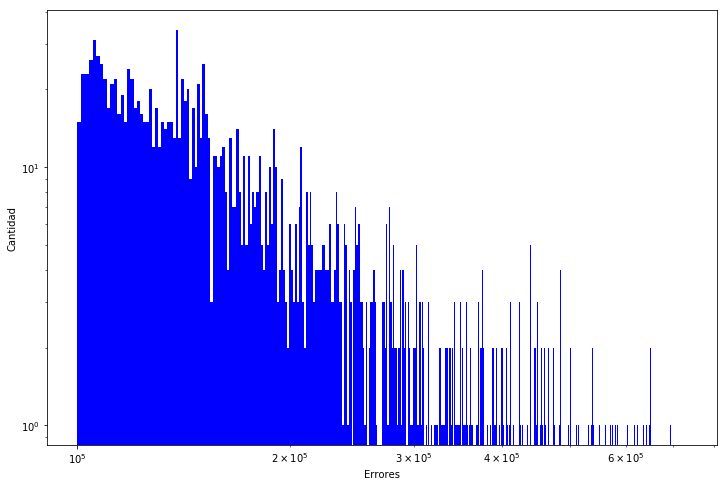

In [67]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(lista, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

### Errores totales

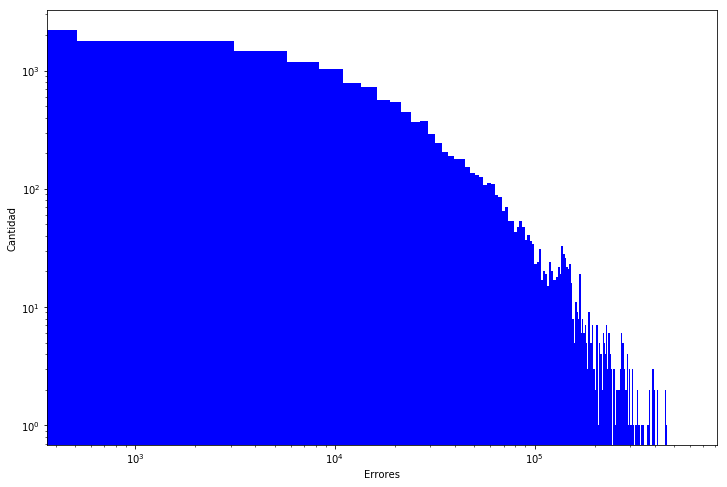

In [68]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

# Kaggle

In [69]:
test_samples=pd.read_csv("datos/properati_dataset_testing_noprice_acondicionado.csv")
test_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    10487 non-null object
lat                        10487 non-null float64
lon                        10487 non-null float64
surface_total_in_m2        14166 non-null float64
surface_covered_in_m2      14166 non-null float64
floor                      1368 non-null float64
rooms                      7500 non-null float64
expenses                   2543 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 1

In [70]:
test= zip(test_samples['surface_total_in_m2'],\
        test_samples['surface_covered_in_m2'],le_barrio.transform(test_samples['place_name']))

In [71]:
resultados = stregr.predict(test)
result=pd.DataFrame({'id':test_samples['id'],'price_usd':resultados})
result.to_csv('datos/resultados.csv',index=False)